In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Загрузка данных
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'class']
dataset = pd.read_csv(url, names=names)
transform = {'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2}
dataset["class"] = dataset["class"].apply(lambda x: transform[x])

# Загружаем данные

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
X_train = pd.read_csv("./UCI HAR Dataset/train/X_train.txt", sep=",", names=[i for i in range(0,561)]).to_numpy()
X_test = pd.read_csv("./UCI HAR Dataset/test/X_test.txt", sep=",", names=[i for i in range(0,561)]).to_numpy()
y_train = pd.read_csv("./UCI HAR Dataset/train/y_train.txt", names=["Y"]).to_numpy()
y_test = pd.read_csv("./UCI HAR Dataset/test/y_test.txt", names=["Y"]).to_numpy()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Класс, который в последствии добавляется в словарь для удобного выбора
class Node:
    def __init__(
        self,
        feature=None,
        threshold=None,
        # childs=None,
        left = None,
        right = None,
        value=None,
        proba_value = None
    ):
        self.feature = feature
        self.threshold = threshold
        # self.childs = childs
        self.value = value
        self.right = right
        self.left = left
        self.proba_value = proba_value

    def is_leaf_node(self):
        return self.value is not None
    


class DecisionTree:
    def __init__(self, max_depth=10, min_samples=10):
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.tree = None
        self.classes = None


    def fit(self, X, y):
        self.classes = np.unique(y)
        self.tree = self.grow_tree(X, y)

    def calck_unic(self, a: list):
        keys = np.unique(a)
        # return {key: a[a == key].shape[0] for key in keys}
        return (a[a == key].shape[0] for key in keys)

    def predict(self, X):
        return np.array([self.travers_tree(x, self.tree) for x in X])

    def predict_proba(self, X):
        return np.array([self.travers_proba_tree(x, self.tree) for x in X])

    def entropy(self, y: np.ndarray):
        hist = self.calck_unic(y)
        n = y.shape[0]
        # hist = {key: val / len(y) for key, val in hist.items()}
        info = -np.sum(np.fromiter((val/n * np.log2(val/n) for val in hist), dtype=np.float64))

        return info
    
    #======================================
    def gini(self, y:np.ndarray):
        uitems = self.calck_unic(y)
        n = y.shape[0]
        return 1 - np.sum(np.fromiter(((val/n)**2 for val in uitems), dtype=np.float64))
    #======================================

    def information_gain(self, X_column: list, y: list, threshold:float):
        if np.unique(y).shape[0] == 1:
            return 0

        n = y.shape[0]
        # info(T)
        # parent = self.entropy(y)
        # uitems = self.calck_unic(X_column)
        #======================================
        left_inds = np.argwhere(X_column <= threshold).flatten()
        right_inds = np.argwhere(X_column > threshold).flatten()
        # print(left_inds)
        # print(X_column.shape)
        # print(y.shape)
        gini_left = self.gini(y[left_inds])
        gini_right = self.gini(y[right_inds])
        gini_split = (len(left_inds) / n) * gini_left +  (len(right_inds) / n) * gini_right
        return gini_split, threshold
        #====================================== 
        # info_x = np.sum(
        #     [val / n * self.entropy(y[X_column == key]) for key, val in uitems.items()]
        # )
        # split_info = -np.sum(
        #     val / n * np.log2(val / n) for val in uitems.values() if val > 0
        # )
        # if split_info != 0:
        #     return (parent - info_x) / split_info, list(uitems.keys())
        # else:
        #     return 0, list(uitems.keys())

    def most_common(self, y):
        labels = np.unique(y)
        vals = self.calck_unic(y)
        return labels[np.argmax(vals)]

    def proba_val(self, y):
        n = y.shape[0]
        probas = np.zeros(self.classes.shape[0])
        vals = self.calck_unic(y)
        keys = np.unique(y)

        probas[np.in1d(self.classes, keys)] = np.fromiter(vals, dtype=np.float64) / n
        return probas

    def best_split(self, X, y):
        best_feature, best_threshold = None, None
        # best_gain = -1
        best_gini = 1000000
        # uitems = []
        for i in range(X.shape[1]):
            #==============================================
            trasholds = np.random.choice(np.unique(X[:, i]), 10)
            # print("new_i")
            for trashold in trasholds:
            #==============================================
                gini, threshold = self.information_gain(X[:, i], y, trashold)
                if gini < best_gini:
                    best_gini = gini
                    best_feature = i
                    best_threshold = threshold

        return best_feature, best_threshold

    def grow_tree(self, X, y, depth=0):
        n_samples = X.shape[0]
        n_labels = np.unique(y).shape[0]
        # print("depth1:", depth)
        if n_samples <= self.min_samples or depth >= self.max_depth or n_labels <= 1:
            return Node(value=self.most_common(y), proba_value=self.proba_val(y))

        #==============================================
        best_feature, best_threshold = self.best_split(X, y)
        l_inds = np.argwhere(X[:, best_feature] <= best_threshold).flatten()
        r_inds = np.argwhere(X[:, best_feature] > best_threshold).flatten()
        # print("depth2:", depth)
        if len(l_inds) == 0 or len(r_inds) == 0:
            return Node(value=self.most_common(y), proba_valUe=self.proba_val(y))
        
        # print("depth3:", depth)
        left = self.grow_tree(X = X[l_inds], y = y[l_inds], depth = depth+1)
        right = self.grow_tree(X = X[r_inds], y = y[r_inds], depth = depth+1)

        return Node(best_feature, best_threshold, left, right)
        #==============================================

        # В словаре содержатся не словари, а Node По сути, словарь содержит ссылки на объекты, а нужен он для более удобной навигации.
        # childs = {
        #     key: self.grow_tree(
        #         X[X[:, best_feature] == key],
        #         y[X[:, best_feature] == key],
        #         depth=depth + 1,
        #     )
        #     for key in ukeys
        # }

        # return Node(best_feature, childs=childs)

    #==============================================
    def travers_tree(self, x, tree):
        if tree.is_leaf_node():
            return tree.value
        
        return self.travers_tree(x, tree.left) if tree.threshold >= x[tree.feature] else self.travers_tree(x, tree.right)

    def travers_proba_tree(self, x, tree):
        if tree.is_leaf_node():
            # print(tree.proba_value)
            return tree.proba_value
        
        return self.travers_proba_tree(x, tree.left) if tree.threshold >= x[tree.feature] else self.travers_proba_tree(x, tree.right)
    #==============================================

    # def travers_tree(self, x, tree):
    #     if tree.is_leaf_node():
    #         return tree.value

    #     return self.travers_tree(
    #         x,
    #         tree.childs.get(
    #             x[tree.feature], tree.childs.get(list(tree.childs.keys())[0])
    #         ),
    #     )


def preload():
    df = pd.read_csv("agaricus-lepiota.csv")
    y = np.array(df.pop("poison"))

    n = df.shape[1]
    to_del = int(n ** 0.5)
    import random

    for i in range(n - to_del - 1):
        df.pop(random.choice(df.columns))
    x = np.array(df)
    return x, y


def acc_pre_rec(otv, y):
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for i in range(len(otv)):
        if otv[i] == "p" and y[i] == "p":
            tp += 1
        elif otv[i] == "p" and y[i] == "e":
            fp += 1
        elif otv[i] == "e" and y[i] == "p":
            fn += 1
        elif otv[i] == "e" and y[i] == "e":
            tn += 1

    acc = (tp + tn) / (tp + tn + fp + fn)
    pre = tp / max((tp + fp), 1)
    rec = tp / max(tp + fn, 1)
    fpr = fp / max(tn + fp, 1)

    return acc, pre, rec, fpr

# x, y = preload()
# print(len(y))


# x = dataset[dataset.columns[:-1]].to_numpy()[:, :2]
# y = dataset["class"].to_numpy()


# clf = DecisionTree(max_depth=2)

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=True)
# clf.fit(x_train, y_train)

# otv = clf.predict(x_test)

# print(f1_score(y_test, otv, average="micro"))

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=True)
# clf.fit(x_train, y_train)

# otv = clf.predict(x_test)
# acc, pre, rec, fpr = acc_pre_rec(y_test, otv)
# print(f"accuracy: {acc}")
# print(f"precision: {pre}")
# print(f"recall: {rec} ")

# points = np.array([[0, 0], [fpr, rec], [1, 1]])
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 7))

# plt.plot(
#     points[:, 0],
#     points[:, 1],
#     "o-r",
#     alpha=0.7,
#     label="first",
#     lw=5,
#     mec="b",
#     mew=2,
#     ms=10,
# )
# plt.fill_between(points[:, 0],
#     points[:, 1], where=None, interpolate=False, step=None)

In [ ]:
class GradientBoosting:
    def __init__(self, learning_rate=0.2, n_estimators=100, max_depth=3):
        """
        :param learning_rate: скорость обучения
        :param n_estimators: количество деревьев
        :param max_depth: максимальная глубина деревьев
        """
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.num_classes = None
        self.base_estimators = []
        
    def sigmoid(self, y_pred):
        """
        :param y_pred: прогноз модели
        :return: значение функции сигмоиды для прогноза
        """
        return 1.0 / (1.0 + np.exp(-y_pred))
    
    def softmax(self, y_pred):
        """
        :param y_pred: прогноз модели
        :return: значение функции softmax для прогноза
        """
        exp_pred = np.exp(y_pred)
        return exp_pred / np.sum(exp_pred, axis=1)[:, np.newaxis]

    def softmax_test(self, y_pred):
        """
        :param y_pred: прогноз модели
        :return: значение функции softmax для прогноза
        """
        exp_pred = np.exp(y_pred)
        return exp_pred / np.sum(exp_pred)
    

    def logloss_gradient(self, y_true, y_pred):
        """
        :param y_true: истинный ответ
        :param y_pred: прогноз модели
        :return: значение градиента функции потерь logLoss
        """
        # p = np.argmax(self.softmax(y_pred))
        # mask = y_true.astype(bool)
        # y_bin = np.zeros((y_true.shape[0], 2))
        # y_bin[mask, 1] = 1
        # y_bin[~mask, 0] = 1
        # print(y_true[:100])
        # print(y_pred[:100])
        p = self.softmax_test(y_pred)
        print("TRUE: ", y_true)
        print("GRAD_pred: ", p)
        return (p - y_true) / y_true.shape[0]
        # return (y_pred - y_true) / y_true.shape[0]
    
    def fit(self, X, y):
        """
        Обучение градиентного бустинга с OneVsAll методом.
        :param X: матрица объектов (numpy array)
        :param y: вектор истинных ответов (numpy array)
        """
        self.num_classes = np.unique(y).shape[0]

        for k in range(self.num_classes):
            y_k = np.where(y == k, 1., 0.)
            # print(y_k)
            # print(y_k)
            # print(y)
            y_pred = np.zeros_like(y_k, dtype=np.float64)
            # print(y_pred)
            estimator = DecisionTree(max_depth=self.max_depth)
            estimator.fit(X, y_k)
            # y_pred += estimator.predict(X)
            self.base_estimators.append((estimator, k))
            y_pred += estimator.predict(X)
            # print(y_pred)
            for m in range(self.n_estimators - 1):

                anti_grad = -self.logloss_gradient(y_k, y_pred)
                print(anti_grad[:]) #ТЫ ЗАКОНЧИЛ НА АНТИГРАДИЕНТЕ, 
                # print(grad)
                if np.unique(anti_grad).shape[0]>1:
                    print("TRUEEEEEEEEEEEEEEEEEEEEEEEEEEEE!!!!!!!!!!!!!")
                    estimator = DecisionTree(max_depth=self.max_depth)
                    # Идём в сторону АНТИГРАДИЕНТА БЛИН, АН-ТИ ГРАДИЕНТА (-2 часа в попытках найти баг в дереве)
                    estimator.fit(X, anti_grad)
                    otv = estimator.predict(X)
                    y_pred += otv #* self.learning_rate
                    #===========================================

                    #===========================================

                self.base_estimators.append((estimator, k))
                
                
    def predict_proba(self, X):
        """
        Предсказание вероятности класса.
        """
        y_pred_proba = np.zeros((X.shape[0], self.num_classes))

        # print(y_pred_proba)
        # А нужен ли этот for?
        for m in range(self.n_estimators):
            flag = 1

            for estimator, k in self.base_estimators:
                y_pred_proba[:, k] += flag * estimator.predict_proba(X)[:,1]

                flag = self.learning_rate
            

        return self.softmax(y_pred_proba / np.linalg.norm(y_pred_proba, axis=1, keepdims=True))
    
    def pred_proba_auc_roc(self, X):

        for m in range(self.n_estimators):
            flag = 1
            y_pred_proba = np.zeros((X.shape[0], self.num_classes, 2))
            for estimator, k in self.base_estimators:
                # print(flag * estimator.predict_proba(X))
                y_pred_proba[:, k] += flag * estimator.predict_proba(X)

                flag = self.learning_rate

        return y_pred_proba

    def predict(self, X):
        """
        Предсказание класса.
        """
        y_pred_proba = self.predict_proba(X)
        return np.argmax(y_pred_proba, axis=1)

In [ ]:
zeros  = np.array([0,0,0,0])
classes = np.array([0.1, 0.75, 0.15, 0.25])
keys = np.array([0.75, 0.25])
vals = np.array([1, 10])

zeros[np.in1d(classes, keys)] = vals
zeros

In [69]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Класс, который в последствии добавляется в словарь для удобного выбора
class Node:
    def __init__(
        self,
        feature=None,
        threshold=None,
        # childs=None,
        left = None,
        right = None,
        value=None,
        proba_value = None
    ):
        self.feature = feature
        self.threshold = threshold
        # self.childs = childs
        self.value = value
        self.right = right
        self.left = left
        self.proba_value = proba_value

    def is_leaf_node(self):
        return self.value is not None
    


class DecisionTree_BOOOOSTED:
    def __init__(self, max_depth=10, min_samples=10):
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.tree = None
        self.classes = None


    def fit(self, X, y):
        self.classes = np.unique(y)
        self.tree = self.grow_tree(X, y)


    def predict(self, X):
        return np.array([self.travers_tree(x, self.tree) for x in X])


    def mse(self, y:np.ndarray):
        return np.mean((np.mean(y)-y)**2)
    
    def mean(self, y):
        return np.mean(y)

    def information_gain(self, X_column: list, y: list, threshold:float):

        n = y.shape[0]


        left_inds = np.argwhere(X_column <= threshold).flatten()
        right_inds = np.argwhere(X_column > threshold).flatten()


        mse_split = 0
        if left_inds.shape[0]!=0:
            mse_left = self.mse(y[left_inds])
            mse_split += (left_inds.shape[0]  / n) * mse_left
        if right_inds.shape[0]!=0:
            mse_right = self.mse(y[right_inds])
            mse_split += (right_inds.shape[0] / n) * mse_right
        return mse_split, threshold


    def best_split(self, X, y):
        best_feature, best_threshold = None, None
        # best_gain = -1
        best_gini = np.inf
        # uitems = []
        for i in range(X.shape[1]):
            #==============================================
            tresholds = np.random.choice(np.unique(X[:, i]), 10)
            # print("hehe")
            # tresholds = np.unique(X[:, i])
            # print("new_i")
            for trashold in tresholds:
            #==============================================
                gini, threshold = self.information_gain(X[:, i], y, trashold)
                if gini < best_gini:
                    # print(gini)
                    best_gini = gini
                    best_feature = i
                    # print(threshold)
                    best_threshold = threshold

        return best_feature, best_threshold

    def grow_tree(self, X, y, depth=0):
        n_samples = X.shape[0]
        n_labels = np.unique(y).shape[0]

        if n_samples <= self.min_samples or depth >= self.max_depth or n_labels <= 1:
            return Node(value=self.mean(y))

        #==============================================
        best_feature, best_threshold = self.best_split(X, y)
        l_inds = np.argwhere(X[:, best_feature] <= best_threshold).flatten()
        r_inds = np.argwhere(X[:, best_feature] > best_threshold).flatten()

        # print(l_inds)
        # print(r_inds) 
        if l_inds.shape[0] == 0 or r_inds.shape[0] == 0:
            return Node(value=self.mean(y))
        
        

        left = self.grow_tree(X = X[l_inds], y = y[l_inds], depth = depth+1)
        right = self.grow_tree(X = X[r_inds], y = y[r_inds], depth = depth+1)

        return Node(best_feature, best_threshold, left, right)


    def travers_tree(self, x, tree):
        if tree.is_leaf_node():
            return tree.value
        
        return self.travers_tree(x, tree.left) if tree.threshold >= x[tree.feature] else self.travers_tree(x, tree.right)


In [83]:
class GradientBoosting:
    def __init__(self, learning_rate=0.2, n_estimators=100, max_depth=3):
        """
        :param learning_rate: скорость обучения
        :param n_estimators: количество деревьев
        :param max_depth: максимальная глубина деревьев
        """
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.num_classes = None
        self.base_estimators = []
        
    def sigmoid(self, y_pred):
        """
        :param y_pred: прогноз модели
        :return: значение функции сигмоиды для прогноза
        """
        return 1.0 / (1.0 + np.exp(-y_pred))
    
    def softmax(self, y_pred):
        """
        :param y_pred: прогноз модели
        :return: значение функции softmax для прогноза
        """
        exp_pred = np.exp(y_pred)
        return exp_pred / np.sum(exp_pred, axis=1)[:, np.newaxis]


    def logloss_gradient(self, y_true, y_pred):
        """
        :param y_true: истинный ответ
        :param y_pred: прогноз модели
        :return: значение градиента функции потерь logLoss
        """
        # p = np.argmax(self.softmax(y_pred))
        # print(y_pred[:100])
        p = y_pred #self.softmax_test(y_pred)
        # print("TRUE: ", y_true)
        # print("GRAD_pred: ", p)
        return (p - y_true) / y_true.shape[0]
        # return (y_pred - y_true) / y_true.shape[0]
    
    def fit(self, X, y):
        """
        Обучение градиентного бустинга с OneVsAll методом.
        :param X: матрица объектов (numpy array)
        :param y: вектор истинных ответов (numpy array)
        """
        self.num_classes = np.unique(y).shape[0]

        for k in range(self.num_classes):
            y_k = np.where(y == k, 1., 0.)
            self.base_estimators.append([])
            y_pred = np.zeros_like(y_k, dtype=np.float64)
            # print(y_pred)
            estimator = DecisionTree_BOOOOSTED(max_depth=self.max_depth)
            estimator.fit(X, y_k)
            # y_pred += estimator.predict(X)
            self.base_estimators[-1].append(estimator)
            y_pred += estimator.predict(X)
            # print(y_pred)
            m=0
            while m < self.n_estimators:
                m+=1
                print("new")
                # print(k, m)
                anti_grad = -self.logloss_gradient(y_k, y_pred)
                # print(anti_grad[:]) #ТЫ ЗАКОНЧИЛ НА АНТИГРАДИЕНТЕ, 
                # print(grad)
                # print("TRUEEEEEEEEEEEEEEEEEEEEEEEEEEEE!!!!!!!!!!!!!")
                estimator = DecisionTree_BOOOOSTED(max_depth=self.max_depth)
                # Идём в сторону АНТИГРАДИЕНТА БЛИН, АН-ТИ ГРАДИЕНТА (-2 часа в попытках найти баг в дереве)
                estimator.fit(X, anti_grad)
                otv =estimator.predict(X)
                # print("OTV!!!!!!!!!!!!", otv)
                y_pred += otv * self.learning_rate
                if np.unique(anti_grad).shape[0]==1:
                    m = self.n_estimators + 1

                self.base_estimators[-1].append(estimator)
                
                
    def predict_proba(self, X):
        """
        Предсказание вероятности класса.
        """
        y_pred_proba = np.zeros((X.shape[0], self.num_classes))

        # print(y_pred_proba)
        # А нужен ли этот for?
        # for m in range(self.n_estimators):
        
        for k, estimators in enumerate(self.base_estimators):
            flag = 1
            for estimator in estimators:
                y_pred_proba[:, k] += flag * estimator.predict(X)

                flag = self.learning_rate
            

        return self.softmax(y_pred_proba / np.linalg.norm(y_pred_proba, axis=1, keepdims=True))
    
    def pred_proba_auc_roc(self, X, class_ind):

        flag = 1
        y_pred_proba = np.zeros(X.shape[0])
        
        flag = 1
        for estimator in self.base_estimators[class_ind]:
            y_pred_proba += flag * estimator.predict(X)

            flag = self.learning_rate

        return y_pred_proba

    def predict(self, X):
        """
        Предсказание класса.
        """
        y_pred_proba = self.predict_proba(X)
        return np.argmax(y_pred_proba, axis=1)

In [121]:
X = dataset[dataset.columns[:-1]].to_numpy()[:, [1,3]]
y = dataset["class"].to_numpy()

x_train, x_text, y_train1, y_test1 = train_test_split(X, y, test_size=0.2)
print(np.unique(y_test.flatten() - 1))

clf = GradientBoosting(max_depth=4, n_estimators=10)
cols = np.array([1,2,3, 41, 42, 43, 81, 82, 83, 121, 122, 123, 161, 162, 163, 201,202,203, 241, 242, 243, 281,282,283, 321,322,323, 361,362,363, 401,402,403]) - 1
clf.fit(X_train[:,cols], y_train.flatten() -1)
# clf.fit(x_train, y_train1)

# otv = clf.predict(x_text)
otv = clf.predict(X_test[:,cols])
# print(otv)
# print(y_test1)
print(f1_score(y_test.flatten() - 1 , otv, average="micro"))
# print(f1_score(y_test1.flatten() , otv, average="micro"))

[0 1 2 3 4 5]
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
new
0.7984390906006108


In [104]:
def sigmoid(y_pred):
    """
    :param y_pred: прогноз модели
    :return: значение функции сигмоиды для прогноза
    """
    return 1.0 / (1.0 + np.exp(-y_pred))

otv1 = clf.pred_proba_auc_roc(X_test[:, cols], 4)[:100]

print(np.where((y_test.flatten()-1)[:100] == 4, 1, 0))
print(np.where(otv1>0.5, 1, 0))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
X = dataset[dataset.columns[:-1]].to_numpy()[:, [1,3]]
y = dataset["class"].to_numpy()
x_train, x_text, y_train1, y_test1 = train_test_split(X, y, test_size=0.2)
y_test1 = np.where(y_test1==1, 1, 0)
y_train1 = np.where(y_train1==1, 1, 0)
clf1 = DecisionTree(max_depth=4)
clf1.fit(x_train, y_train1)

otv = clf1.predict(x_text)
print(otv)
print(y_test1)
print(f1_score(y_test1.flatten(), otv, average="micro"))
# otv = clf.predict(X_test[:,c
# clf1.fit(X_train[:,cols], y_train.flatten() - 1)

# otv = clf1.predict(X_test[:,cols])
# # otv_prob = clf.predict_proba(x_text)
# print(otv)
# print(f1_score(y_test.flatten() - 1, otv, average="micro"))

In [128]:
def AUC_ROC(y_true, y_pred_proba, class_ind=1):
    # y_true1, y_pred_proba_1 = list(zip(*list(sorted(zip(y_true, y_pred_proba), key = lambda x : x[1]))))
    sorted_indices = np.argsort(y_pred_proba)[::-1]
    sorted_y_true = y_true[sorted_indices]
    sorted_y_pred = y_pred_proba[sorted_indices]
    print(sorted_y_pred)
    print(sorted_y_true)
    otv_list_y = []
    otv_list_x = []
    flag_y = 0
    flag_x = 0
    for y in sorted_y_true:
        if y == 1:
            flag_y+=1
        else:
            flag_x += 1
        otv_list_y.append(flag_y)
        otv_list_x.append(flag_x)

    otv_list_x = np.array(otv_list_x)
    otv_list_y = np.array(otv_list_y)
    plt.plot(otv_list_x/otv_list_x[-1], otv_list_y/otv_list_y[-1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'AUC - ROC Curve for class: {class_ind}')
    plt.show()


def AUC_ROC_one_vs_all(clf, y_true, X_test):
    for i in np.sort(np.unique(y_true)):
        print(i)
        AUC_ROC(np.where((y_true) == i, 1, 0), clf.pred_proba_auc_roc(X_test, i), class_ind=i)

0
[ 1.00005070e+00  1.00004093e+00  1.00003801e+00 ... -5.25407317e-05
 -5.76970305e-05 -6.65968008e-05]
[1 1 1 ... 0 0 0]


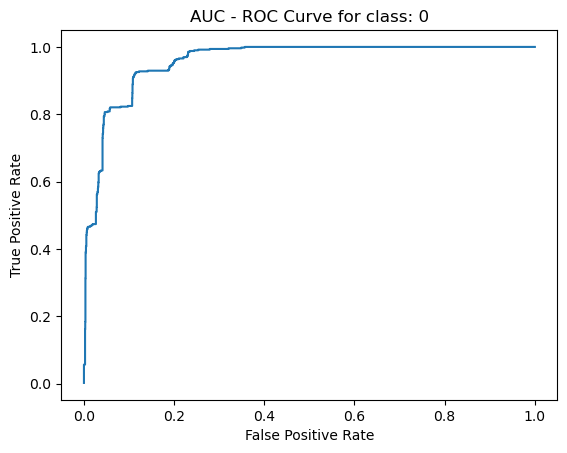

1
[ 9.27308185e-01  9.27307685e-01  9.27302816e-01 ... -1.25467015e-05
 -1.93336455e-05 -3.29897231e-05]
[1 1 1 ... 0 0 0]


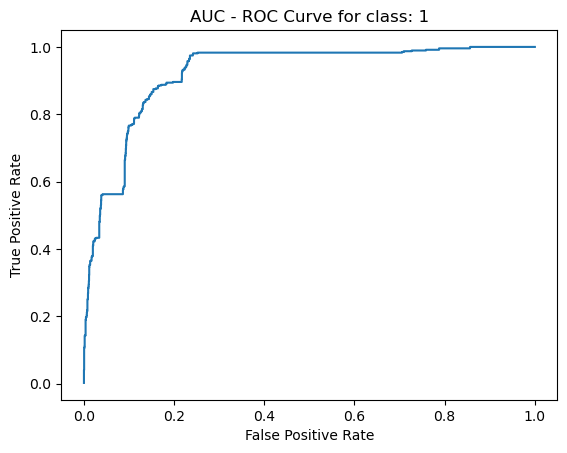

2
[ 9.88483826e-01  9.88478805e-01  9.88478805e-01 ... -1.44605019e-05
 -1.45403045e-05 -2.61700923e-05]
[1 1 1 ... 0 0 0]


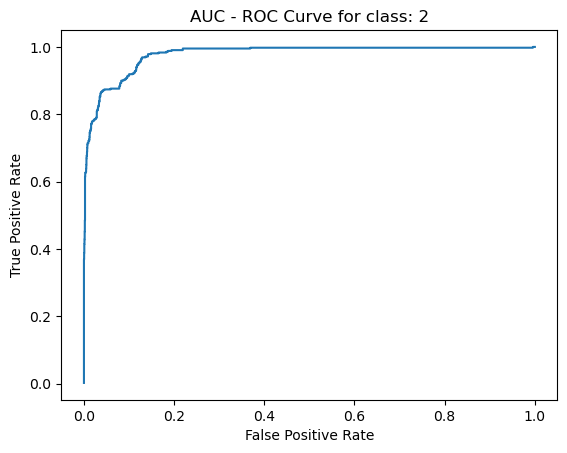

3
[ 9.89171209e-01  9.89171209e-01  9.89170795e-01 ... -2.57011397e-05
 -3.84210120e-05 -5.04463320e-05]
[1 1 1 ... 0 0 0]


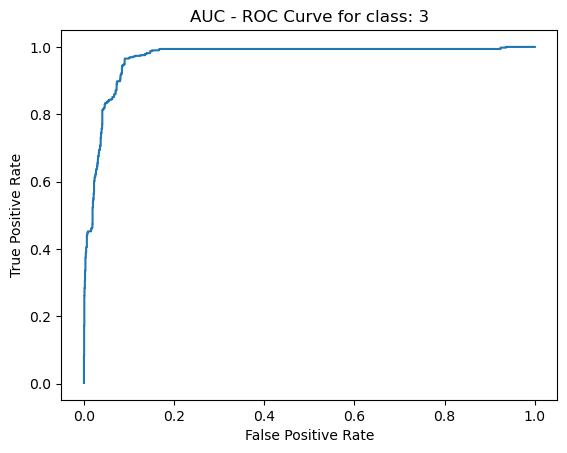

4
[ 1.00000769e+00  1.00000315e+00  1.00000185e+00 ... -6.17008004e-05
 -6.17255073e-05 -6.17255073e-05]
[1 1 0 ... 0 0 0]


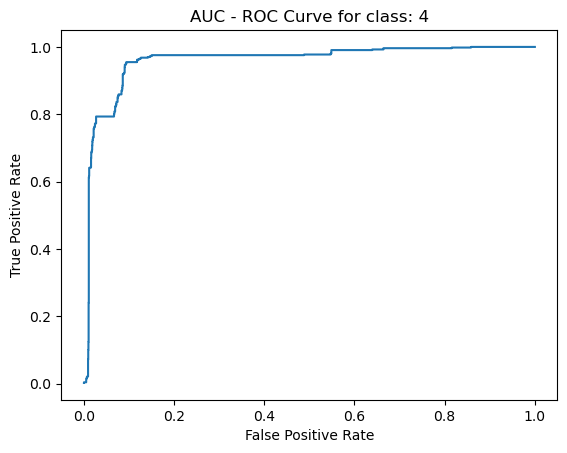

5
[ 1.00000511e+00  1.00000454e+00  1.00000371e+00 ... -5.04061074e-06
 -5.04556898e-06 -1.26449798e-05]
[1 1 1 ... 0 0 0]


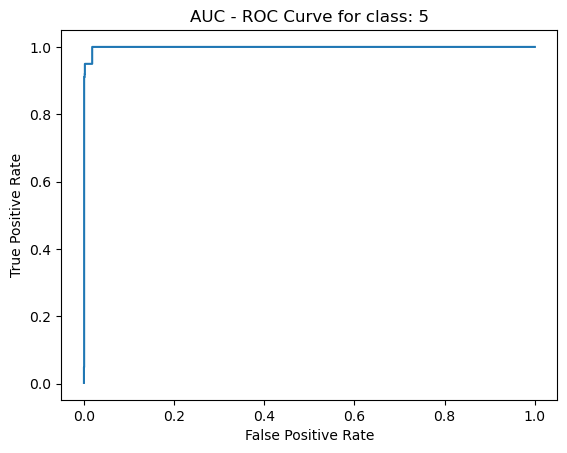

In [129]:
# AUC_ROC(np.where((y_test.flatten()-1) == 4, 1, 0), clf.pred_proba_auc_roc(X_test[:, cols], 4))
AUC_ROC_one_vs_all(clf, y_test.flatten()-1, X_test[:, cols])

In [136]:
def pre_rec_f1(y_true, y_pred):
    precision_list = []
    recall_list = []
    f1_list = []
    for i in np.unique(y_true):
        tp = np.sum((y_pred == i) * (y_true == i))
        fp = np.sum((y_pred==i) * (y_true != i))
        fn = np.sum((y_pred!=i) * (y_true == i))
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        f1 = 2*precision*recall/(precision+recall)

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

        print(f"For {i} class {precision=}")
        print(f"For {i} class {recall=}")
        print(f"For {i} class {f1=}")
    
    print(f"Macro precision = {sum(precision_list)/len(precision_list)}")
    print(f"Macro recall = {sum(recall_list)/len(recall_list)}")
    print(f"Macro f1 = {sum(f1_list)/len(f1_list)}")
    print(f"accuracy = {np.sum(y_pred==y_true)/y_true.shape[0]}")

pre_rec_f1(y_test.flatten() - 1, otv)

For 0 class precision=0.6781818181818182
For 0 class recall=0.7520161290322581
For 0 class f1=0.7131931166347995
For 1 class precision=0.6736401673640168
For 1 class recall=0.6836518046709129
For 1 class f1=0.678609062170706
For 2 class precision=0.8873626373626373
For 2 class recall=0.7690476190476191
For 2 class f1=0.8239795918367347
For 3 class precision=0.787819253438114
For 3 class recall=0.8167006109979633
For 3 class f1=0.802
For 4 class precision=0.7984934086629002
For 4 class recall=0.7969924812030075
For 4 class f1=0.7977422389463782
For 5 class precision=0.9902912621359223
For 5 class recall=0.9497206703910615
For 5 class f1=0.9695817490494297
Macro precision = 0.8026314245242347
Macro recall = 0.7946882192238037
Macro f1 = 0.7975176264396747
accuracy = 0.7984390906006108


In [12]:
import numpy as np
def softmax(y_pred):
    """
    :param y_pred: прогноз модели
    :return: значение функции softmax для прогноза
    """
    exp_pred = np.exp(y_pred)
    return exp_pred / np.sum(exp_pred, axis=1)[:, np.newaxis]

def sigmoid(y_pred):
    """
    :param y_pred: прогноз модели
    :return: значение функции сигмоиды для прогноза
    """
    return 1.0 / (1.0 + np.exp(-y_pred))

y = np.array([[0.4,0,0,0.6],
              [0.3,0.2,0.2,0.2]])
y[np.argmax(y, axis=1)==0, 0]
np.hstack((y[np.argmax(y, axis=1)==0, 0], y[np.argmax(y, axis=1)!=0, 0]))


array([0.3, 0.4])